Importing libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Computation analysis

In [2]:
nkeys = 2
length = 1000000
data2 = pd.read_csv(f'./results/seq_{nkeys}_{length}_log.csv', header=None)
data2.columns = ['loop', 'iteration', 'm', 'n']
data2['mat_size'] = data2['m']*data2['n']
data2.sort_values(by='mat_size', inplace=True)
data2

,loop,iteration,m,n,mat_size
41667,second,2,16,16,256
41666,second,1,16,16,256
41664,first,999999,64,64,4096
27772,first,666591,64,64,4096
27773,first,666591,64,64,4096
...,...,...,...,...,...
13891,first,333423,64,64,4096
13892,first,333471,64,64,4096
13893,first,333471,64,64,4096
13875,first,333039,64,64,4096


In [3]:
print(f'Percentage of computations in the first loop when nkeys={nkeys}: {len(data2[data2["loop"]=="first"])/len(data2)*100:.4f}%')
print(f'Percentage of computations in the second loop when nkeys={nkeys}: {len(data2[data2["loop"]=="second"])/len(data2)*100:.4f}%')

Percentage of computations in the first loop when nkeys=2: 99.9952%
Percentage of computations in the second loop when nkeys=2: 0.0048%


In [4]:
num_it_parallel_2 = data2[data2['loop']=='first'].groupby('iteration').size().value_counts().values[0]
tot_it_2 = len(data2[data2['loop']=='first']['iteration'].unique())
print(f"Percentage of iterations in the first loop with two computations when nkeys={nkeys}: {(num_it_parallel_2/tot_it_2)*100:.2f} %")
print(f"Number of computations in the second loop when nkeys={nkeys}: {len(data2[(data2['loop']=='second')])}")

Percentage of iterations in the first loop with two computations when nkeys=2: 100.00 %
Number of computations in the second loop when nkeys=2: 2


In [5]:
nkeys = 100
data100 = pd.read_csv(f'./results/seq_{nkeys}_{length}_log.csv', header=None)
data100.columns = ['loop', 'iteration', 'm', 'n']
data100['mat_size'] = data100['m']*data100['n']
data100.sort_values(by='mat_size', inplace=True)
data100

,loop,iteration,m,n,mat_size
36308,second,548,2,1,2
40380,second,4845,1,2,2
40091,second,4548,2,1,2
40341,second,4805,1,2,2
38442,second,2848,3,1,3
...,...,...,...,...,...
30623,first,856041,64,64,4096
2329,first,66879,64,64,4096
30640,first,856621,64,64,4096
9553,first,268087,64,64,4096


In [6]:
print(f'Percentage of computations in the first loop when nkeys={nkeys}: {len(data100[data100["loop"]=="first"])/len(data100)*100:.4f}%')
print(f'Percentage of computations in the second loop when nkeys={nkeys}: {len(data100[data100["loop"]=="second"])/len(data100)*100:.4f}%')

Percentage of computations in the first loop when nkeys=100: 79.0076%
Percentage of computations in the second loop when nkeys=100: 20.9924%


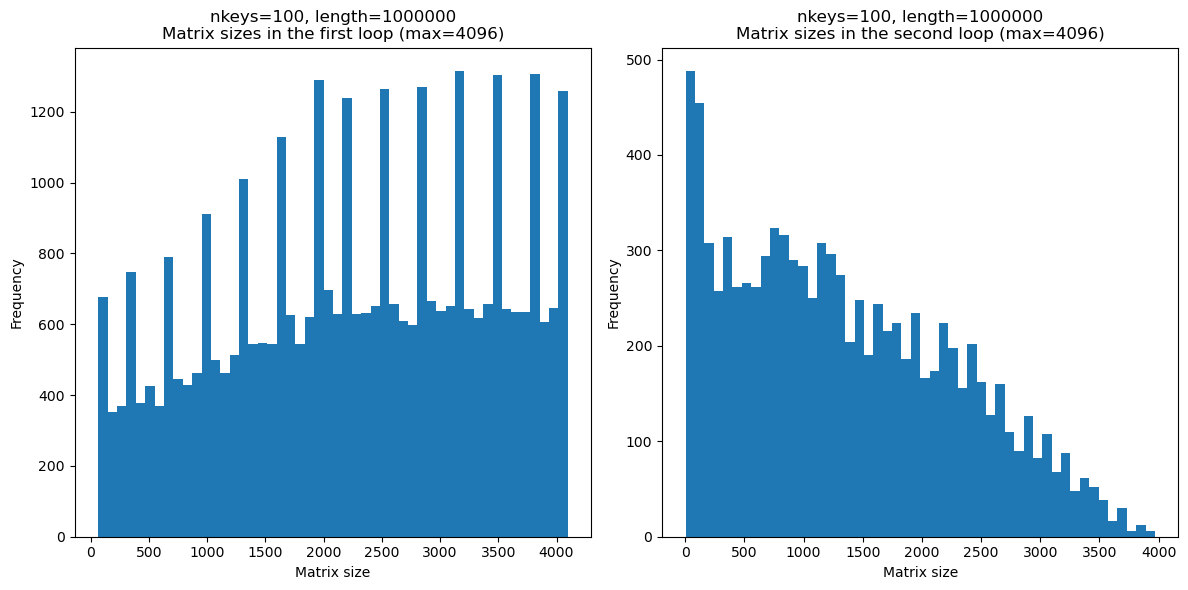

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

data100[data100['loop']=='first'].plot(
    kind='hist', y='mat_size', bins=50, ax=axs[0],
    title=f'nkeys={nkeys}, length={length}\nMatrix sizes in the first loop (max={64*64})',
    xlabel='Matrix size')

data100[data100['loop']=='second'].plot(
    kind='hist', y='mat_size', bins=50, ax=axs[1],
    title=f'nkeys={nkeys}, length={length}\nMatrix sizes in the second loop (max={64*64})',
    xlabel='Matrix size')

for ax in axs:
    ax.get_legend().remove()

fig.tight_layout()
fig.savefig(f'./img/{nkeys}_mat_sizes.png')

In [8]:
num_it_parallel_100 = data100[data100['loop']=='first'].groupby('iteration').size().value_counts().values[1]
tot_it_100 = len(data100[data100['loop']=='first']['iteration'].unique())
print(f"Percentage of iterations in the first loop with two computations when nkeys={nkeys}: {(num_it_parallel_100/tot_it_100)*100:.2f} %")
print(f"Number of computations in the second loop when nkeys={nkeys}: {len(data100[(data100['loop']=='second')])}")

Percentage of iterations in the first loop with two computations when nkeys=100: 0.89 %
Number of computations in the second loop when nkeys=100: 9506


# Performance analysis

Loading execution timings of the sequential implementation when testing for strong scaling:

In [9]:
seq_data_strong = pd.read_csv('./results/seq_timing_strong.csv', header=None)
seq_data_strong.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
seq_data_strong

,ntasks,nkeys,length,threshold,time
0,1,2,1000000,-1,8.424393
1,1,2,1000000,-1,8.415355
2,1,2,1000000,-1,8.416197
3,1,2,1000000,-1,8.429321
4,1,2,1000000,-1,8.422456
...,...,...,...,...,...
235,1,500,1000000,-1,27.273569
236,1,500,1000000,-1,27.287380
237,1,500,1000000,-1,27.294827
238,1,500,1000000,-1,27.290701


Grouping data:

In [10]:
seq_data_grouped = seq_data_strong.groupby(['ntasks', 'nkeys', 'length'])['time'].agg(['mean', 'median', 'std'])
seq_data_grouped.reset_index(inplace=True)
seq_data_grouped

,ntasks,nkeys,length,mean,median,std
0,1,2,1000000,8.432893,8.424246,0.046575
1,1,100,1000000,5.345198,5.344265,0.004208
2,1,500,1000000,27.276241,27.275886,0.022383


## Analysis on 8-Node cluster

### Strong scaling

Loading execution timings when using 8 nodes and testing for strong scaling:

In [11]:
par_data_8nodes_strong = pd.read_csv('./results/par_timing_strong_8nodes.csv', header=None)
par_data_8nodes_strong.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
par_data_8nodes_strong

,ntasks,nkeys,length,threshold,time
0,2,2,1000000,0,8.021580
1,2,2,1000000,0,7.914333
2,2,2,1000000,0,7.983956
3,2,2,1000000,0,7.987487
4,2,2,1000000,0,8.015673
...,...,...,...,...,...
235,64,100,1000000,4096,18.702138
236,64,100,1000000,4096,20.549934
237,64,100,1000000,4096,20.604015
238,64,100,1000000,4096,20.375995


Grouping data:

In [12]:
par_data_8nodes_strong_grouped = par_data_8nodes_strong.groupby(['ntasks', 'nkeys', 'length', 'threshold'])['time'].agg(['mean', 'median', 'std'])
par_data_8nodes_strong_grouped.reset_index(inplace=True)
par_data_8nodes_strong_grouped

,ntasks,nkeys,length,threshold,mean,median,std
0,2,2,1000000,0,7.966333,7.981488,0.050124
1,2,2,1000000,4096,7.526700,7.538576,0.079550
2,2,100,1000000,0,8.415462,8.385334,0.125867
3,2,100,1000000,4096,7.731051,7.694130,0.083362
4,4,2,1000000,0,12.311585,12.277143,0.199300
5,4,2,1000000,4096,12.311192,12.319807,0.051076
6,4,100,1000000,0,13.720283,13.746036,0.146781
7,4,100,1000000,4096,12.484325,12.458046,0.097460
8,8,2,1000000,0,15.423452,15.430319,0.225299
9,8,2,1000000,4096,14.990919,14.941594,0.109764


Plotting box plot of execution timings:

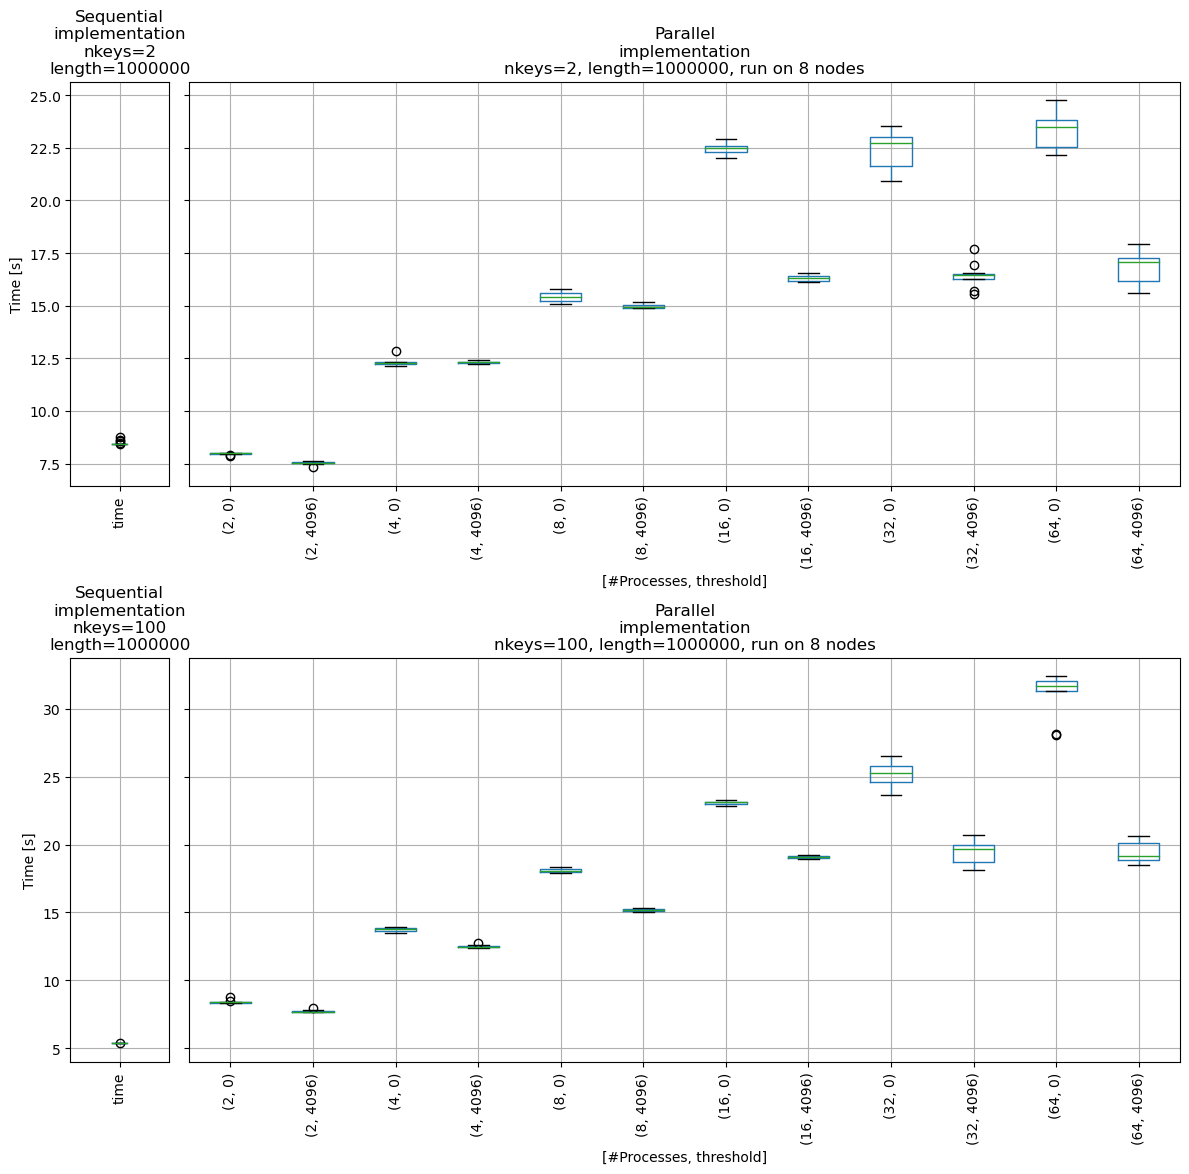

In [13]:
fig, axs = plt.subplots(2,2,figsize=(12,12), sharey='row', gridspec_kw={'width_ratios': [1, 10]})

seq_data_strong[seq_data_strong['nkeys']==2].boxplot(column="time", rot=90, ax=axs[0][0], ylabel='Time [s]')
axs[0][0].set_title(f'Sequential\nimplementation\nnkeys=2\nlength={length}')
par_data_8nodes_strong[par_data_8nodes_strong['nkeys']==2].boxplot(column="time", by=['ntasks', 'threshold'], rot=90, ax=axs[0][1])
axs[0][1].set_title(f'Parallel\nimplementation\nnkeys=2, length={length}, run on 8 nodes')
axs[0][1].set_xlabel('[#Processes, threshold]')

seq_data_strong[seq_data_strong['nkeys']==100].boxplot(column="time", rot=90, ax=axs[1][0], ylabel='Time [s]')
axs[1][0].set_title(f'Sequential\nimplementation\nnkeys=100\nlength={length}')
par_data_8nodes_strong[par_data_8nodes_strong['nkeys']==100].boxplot(column="time", by=['ntasks', 'threshold'], rot=90, ax=axs[1][1])
axs[1][1].set_title(f'Parallel\nimplementation\nnkeys=100, length={length}, run on 8 nodes')
axs[1][1].set_xlabel('[#Processes, threshold]')

fig.suptitle('')
fig.tight_layout()
fig.savefig(f"img/times_box_8nodes_strong.png")

Computing speedup for the best configuration:

In [14]:
best_par_time_0 = par_data_8nodes_strong_grouped[
    (par_data_8nodes_strong_grouped['ntasks']==2) &
    (par_data_8nodes_strong_grouped['nkeys']==2) &
    (par_data_8nodes_strong_grouped['threshold']==0)
    ]['median'].values[0]
best_par_time_4096 = par_data_8nodes_strong_grouped[
    (par_data_8nodes_strong_grouped['ntasks']==2) &
    (par_data_8nodes_strong_grouped['nkeys']==2) &
    (par_data_8nodes_strong_grouped['threshold']==4096)
    ]['median'].values[0]
seq_time = seq_data_grouped[seq_data_grouped['nkeys']==2]['median'].values[0]
pd.DataFrame({
    'Speedup with nkeys=2, length=1000000, ntasks=2': [
        seq_time/best_par_time_0,
        seq_time/best_par_time_4096
    ],
    'Threshold': [0, 4096]
    }).set_index('Threshold')

,"Speedup with nkeys=2, length=1000000, ntasks=2"
Threshold,
0,1.055473
4096,1.117485


### Weak scalability analysis

Loading execution timings of the sequential implementation when testing for weak scaling:

In [15]:
seq_data_weak = pd.read_csv('./results/seq_timing_weak.csv', header=None)
seq_data_weak.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
seq_data_weak

,ntasks,nkeys,length,threshold,time
0,1,50,1000000,-1,4.537941
1,1,50,1000000,-1,4.537775
2,1,50,1000000,-1,4.539684
3,1,50,1000000,-1,4.543544
4,1,50,1000000,-1,4.539730
...,...,...,...,...,...
395,1,800,1000000,-1,63.402565
396,1,800,1000000,-1,63.415834
397,1,800,1000000,-1,63.440405
398,1,800,1000000,-1,63.443247


Grouping data:

In [16]:
seq_data_weak_grouped = seq_data_weak.groupby(['ntasks', 'nkeys', 'length'])['time'].agg(['mean', 'median', 'std'])
seq_data_weak_grouped.reset_index(inplace=True)
seq_data_weak_grouped.rename(columns={'median': 'seq_median'}, inplace=True)
seq_data_weak_grouped

,ntasks,nkeys,length,mean,seq_median,std
0,1,50,1000000,4.543581,4.542133,0.007374
1,1,100,1000000,5.351086,5.346449,0.025185
2,1,200,1000000,8.548860,8.547871,0.011680
3,1,400,1000000,19.715118,19.708188,0.037018
4,1,800,1000000,63.419915,63.418055,0.055674


Loading execution timings of the parallel implementation when testing for weak scaling:

In [17]:
par_data_8nodes_weak = pd.read_csv('./results/par_timing_weak_8nodes.csv', header=None)
par_data_8nodes_weak.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
par_data_8nodes_weak

,ntasks,nkeys,length,threshold,time
0,2,50,1000000,0,7.934100
1,2,50,1000000,0,7.933515
2,2,50,1000000,0,7.892950
3,2,50,1000000,0,7.903293
4,2,50,1000000,0,7.884558
...,...,...,...,...,...
145,32,800,1000000,4096,20.601326
146,32,800,1000000,4096,21.486872
147,32,800,1000000,4096,21.091299
148,32,800,1000000,4096,20.498284


Grouping data:

In [18]:
par_data_8nodes_weak_grouped = par_data_8nodes_weak.groupby(['ntasks', 'nkeys', 'length', 'threshold'])['time'].agg(['mean', 'median', 'std'])
par_data_8nodes_weak_grouped.reset_index(inplace=True)
par_data_8nodes_weak_grouped.rename(columns={'median': 'par_median'}, inplace=True)
par_data_8nodes_weak_grouped

,ntasks,nkeys,length,threshold,mean,par_median,std
0,2,50,1000000,0,7.918573,7.917474,0.028680
1,2,50,1000000,2048,7.553904,7.538165,0.061207
2,2,50,1000000,4096,7.308649,7.251016,0.145386
3,4,100,1000000,0,13.638491,13.592955,0.128613
4,4,100,1000000,2048,13.100551,13.075972,0.100121
5,4,100,1000000,4096,12.510307,12.514223,0.096122
6,8,200,1000000,0,18.503234,18.472144,0.079382
7,8,200,1000000,2048,17.882391,17.800359,0.348670
8,8,200,1000000,4096,15.703787,15.662344,0.108557
9,16,400,1000000,0,23.946016,23.961563,0.087698


Computing performance metrics in the weak scaling setting:

In [19]:
data_weak_8nodes = seq_data_weak_grouped[['nkeys', 'seq_median']].merge(par_data_8nodes_weak_grouped, on=['nkeys'])
data_weak_8nodes['speedup'] = data_weak_8nodes['seq_median']/data_weak_8nodes['par_median']
data_weak_8nodes['cost'] = data_weak_8nodes['par_median']*data_weak_8nodes['ntasks']
data_weak_8nodes['efficiency'] = data_weak_8nodes['speedup']/data_weak_8nodes['ntasks']
data_weak_8nodes[['nkeys', 'threshold', 'ntasks', 'seq_median', 'par_median', 'speedup', 'cost', 'efficiency']]

,nkeys,threshold,ntasks,seq_median,par_median,speedup,cost,efficiency
0,50,0,2,4.542133,7.917474,0.573685,15.834949,0.286842
1,50,2048,2,4.542133,7.538165,0.602551,15.076331,0.301276
2,50,4096,2,4.542133,7.251016,0.626413,14.502032,0.313207
3,100,0,4,5.346449,13.592955,0.393325,54.371820,0.098331
4,100,2048,4,5.346449,13.075972,0.408876,52.303888,0.102219
5,100,4096,4,5.346449,12.514223,0.427230,50.056894,0.106807
6,200,0,8,8.547871,18.472144,0.462744,147.777156,0.057843
7,200,2048,8,8.547871,17.800359,0.480208,142.402872,0.060026
8,200,4096,8,8.547871,15.662344,0.545759,125.298756,0.068220
9,400,0,16,19.708188,23.961563,0.822492,383.385008,0.051406


Plotting metrics:

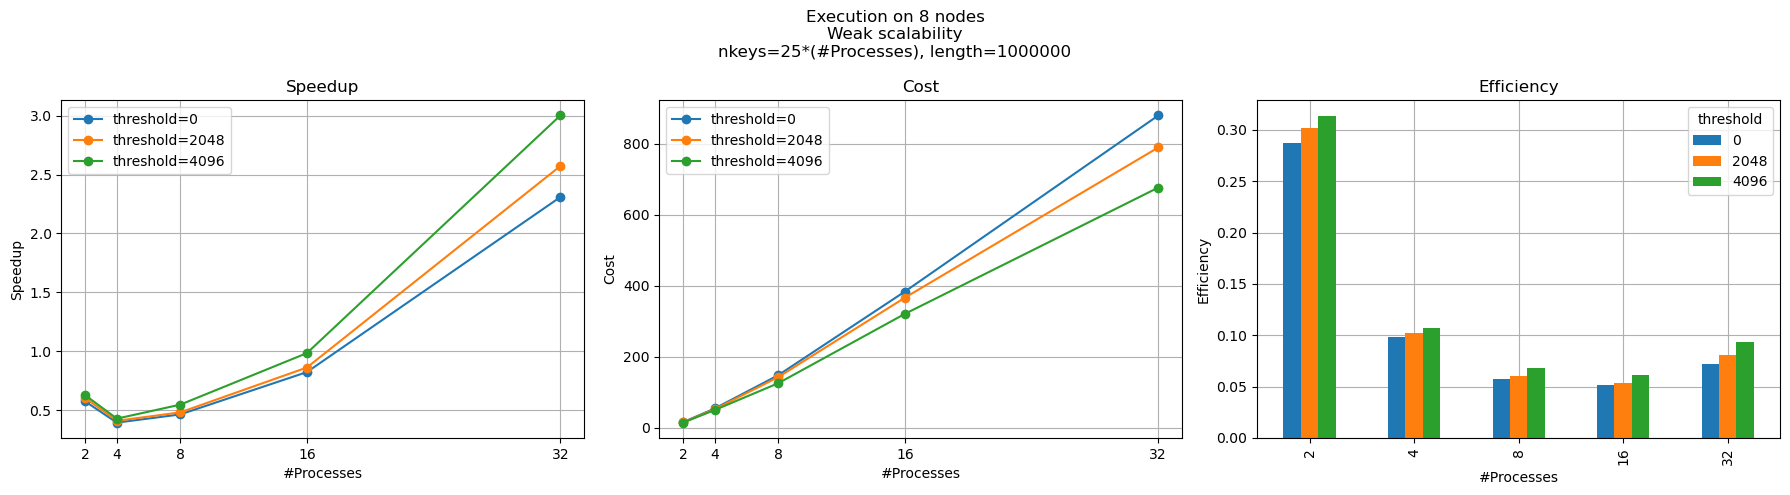

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plotting speedup
for threshold in enumerate(data_weak_8nodes['threshold'].unique()): # for each threshold
    thr = threshold[1]
    data_weak_8nodes[data_weak_8nodes['threshold']==thr].plot(
    x='ntasks', y='speedup',
    xlabel='#Processes', label=f'threshold={thr}', style='o-', ax=axs[0])
axs[0].set_ylabel('Speedup')
axs[0].grid()
processes = data_weak_8nodes['ntasks'].unique()
axs[0].set_xticks(ticks=processes, labels=processes)
axs[0].set_title(f'Speedup');

# Plotting cost
for threshold in enumerate(data_weak_8nodes['threshold'].unique()): # for each threshold
    thr = threshold[1]
    data_weak_8nodes[data_weak_8nodes['threshold']==thr].plot(
    x='ntasks', y='cost',
    xlabel='#Processes', label=f'threshold={thr}', style='o-', ax=axs[1])
axs[1].set_ylabel('Cost')
axs[1].grid()
processes = data_weak_8nodes['ntasks'].unique()
axs[1].set_xticks(ticks=processes, labels=processes)
axs[1].set_title(f'Cost');

# Plotting efficiency
pivot_weak_8nodes = data_weak_8nodes.pivot(index='ntasks', columns='threshold', values='efficiency')
pivot_weak_8nodes.plot.bar(grid=True, ax=axs[2])
axs[2].set_ylabel('Efficiency')
axs[2].set_xlabel('#Processes')
axs[2].set_axisbelow(True)
axs[2].set_title(f'Efficiency');

fig.suptitle(f'Execution on 8 nodes\nWeak scalability\nnkeys=25*(#Processes), length={length}')
fig.tight_layout()
fig.savefig('./img/metrics_8nodes_weak.png')

## Analysis on a single node

### Strong scalability analysis

Loading execution timings when using 1 node and testing for strong scalability:

In [21]:
par_data_1node = pd.read_csv('./results/par_timing_strong_1node.csv', header=None)
par_data_1node.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
par_data_1node

,ntasks,nkeys,length,threshold,time
0,2,2,1000000,0,4.552638
1,2,2,1000000,0,4.556009
2,2,2,1000000,0,4.550877
3,2,2,1000000,0,4.550610
4,2,2,1000000,0,4.567439
...,...,...,...,...,...
445,32,500,1000000,4096,10.036398
446,32,500,1000000,4096,10.049821
447,32,500,1000000,4096,10.050527
448,32,500,1000000,4096,10.113988


Grouping data:

In [22]:
par_data_1node_grouped = par_data_1node.groupby(['ntasks', 'nkeys', 'length', 'threshold'])['time'].agg(['mean', 'median', 'std'])
par_data_1node_grouped.reset_index(inplace=True)
par_data_1node_grouped

,ntasks,nkeys,length,threshold,mean,median,std
0,2,2,1000000,0,4.561257,4.554324,0.019670
1,2,2,1000000,2048,4.563445,4.561431,0.032822
2,2,2,1000000,4096,4.158862,4.133721,0.069737
3,2,100,1000000,0,3.802182,3.795522,0.028335
4,2,100,1000000,2048,4.018934,4.010647,0.031193
5,2,100,1000000,4096,4.819144,4.811521,0.044551
6,2,500,1000000,0,12.850814,12.845079,0.033393
7,2,500,1000000,2048,13.075879,13.057659,0.049183
8,2,500,1000000,4096,13.882516,13.834020,0.113727
9,4,2,1000000,0,3.506850,3.472732,0.092026


Plotting box plot of execution timings:

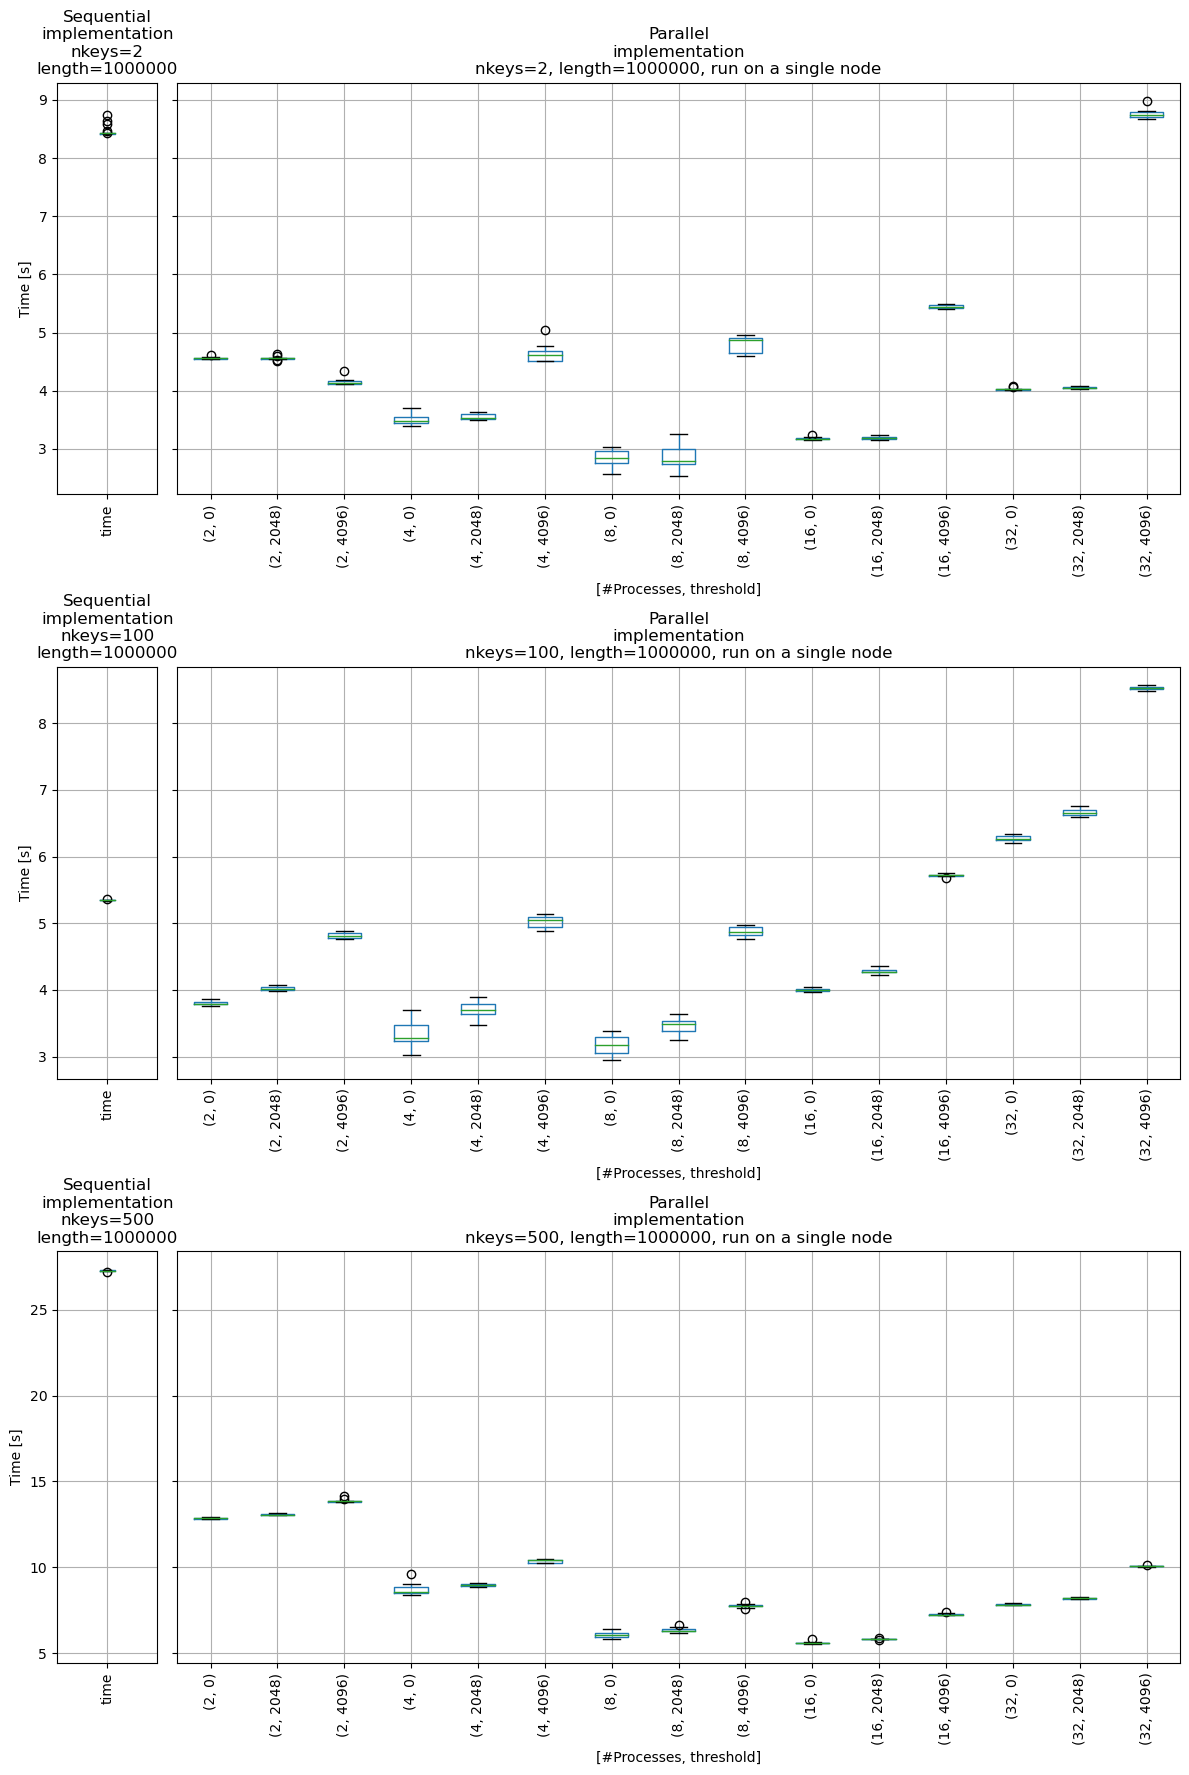

In [23]:
fig, axs = plt.subplots(3,2,figsize=(12,18), sharey='row', gridspec_kw={'width_ratios': [1, 10]})

seq_data_strong[seq_data_strong['nkeys']==2].boxplot(column="time", rot=90, ax=axs[0][0], ylabel='Time [s]')
axs[0][0].set_title(f'Sequential\nimplementation\nnkeys=2\nlength={length}')
par_data_1node[par_data_1node['nkeys']==2].boxplot(column="time", by=['ntasks', 'threshold'], rot=90, ax=axs[0][1])
axs[0][1].set_title(f'Parallel\nimplementation\nnkeys=2, length={length}, run on a single node')
axs[0][1].set_xlabel('[#Processes, threshold]')

seq_data_strong[seq_data_strong['nkeys']==100].boxplot(column="time", rot=90, ax=axs[1][0], ylabel='Time [s]')
axs[1][0].set_title(f'Sequential\nimplementation\nnkeys=100\nlength={length}')
par_data_1node[par_data_1node['nkeys']==100].boxplot(column="time", by=['ntasks', 'threshold'], rot=90, ax=axs[1][1])
axs[1][1].set_title(f'Parallel\nimplementation\nnkeys=100, length={length}, run on a single node')
axs[1][1].set_xlabel('[#Processes, threshold]')

seq_data_strong[seq_data_strong['nkeys']==500].boxplot(column="time", rot=90, ax=axs[2][0], ylabel='Time [s]')
axs[2][0].set_title(f'Sequential\nimplementation\nnkeys=500\nlength={length}')
par_data_1node[par_data_1node['nkeys']==500].boxplot(column="time", by=['ntasks', 'threshold'], rot=90, ax=axs[2][1])
axs[2][1].set_title(f'Parallel\nimplementation\nnkeys=500, length={length}, run on a single node')
axs[2][1].set_xlabel('[#Processes, threshold]')

fig.suptitle('')
fig.tight_layout()
fig.savefig(f"img/times_box_1node_strong.png")

Plotting times in a line plot:

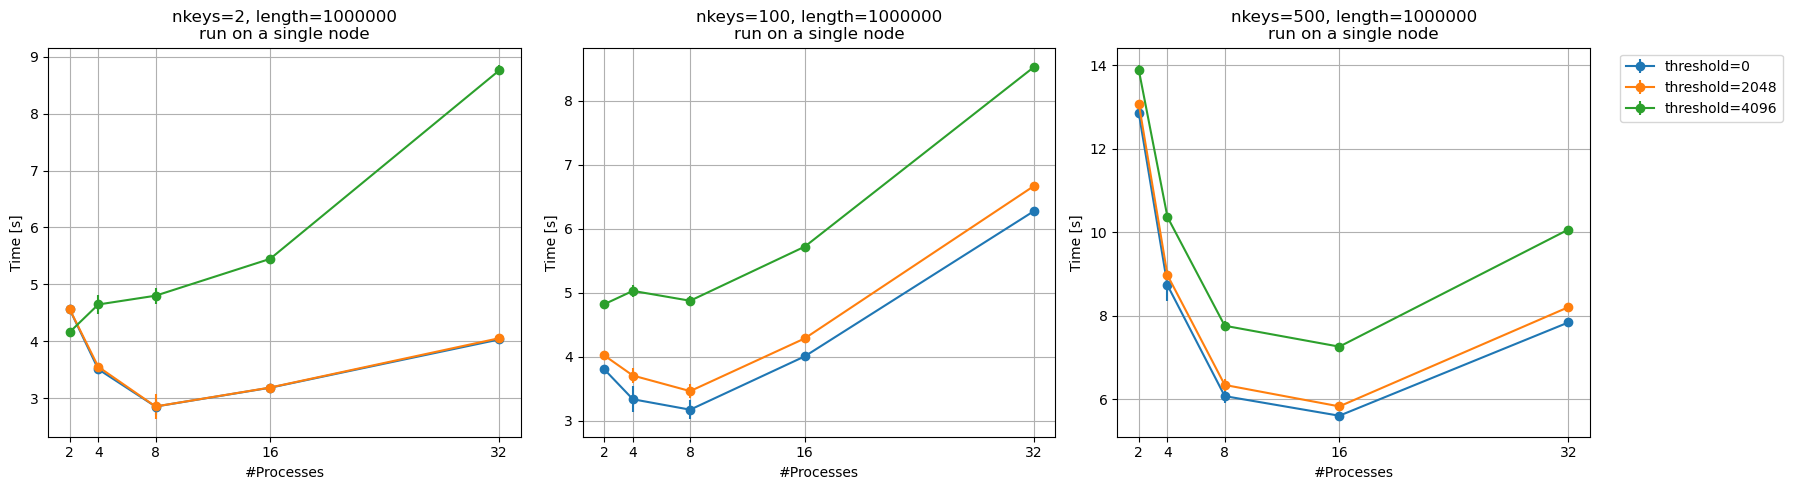

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
processes = par_data_1node_grouped['ntasks'].unique()
nkeys = par_data_1node_grouped['nkeys'].unique()
for i, nkeys in enumerate(nkeys): # for each number of keys
    for threshold in par_data_1node_grouped['threshold'].unique(): # for each threshold
        par_data_1node_grouped[
            (par_data_1node_grouped['nkeys']==nkeys)
            &(par_data_1node_grouped['threshold']==threshold)
        ].plot(
            x='ntasks', y='mean', yerr='std',
            ax=axs[i], label=f"threshold={threshold}", linestyle='-', marker='o'
        )
    axs[i].set_xlabel("#Processes")
    axs[i].set_ylabel("Time [s]")
    axs[i].set_xticks(ticks=processes, labels=processes)
    axs[i].set_title(f"nkeys={nkeys}, length={length}\nrun on a single node")
    axs[i].get_legend().remove()
    axs[i].grid()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left');
fig.tight_layout()
fig.savefig(f"img/times_line_1node_strong.png")

Defining a function to compute performance metrics:

In [25]:
def compute_metrics(df, seq_time):
    speedup = seq_time / df["median"]
    speedup.name = "speedup"

    cost = df["median"]*df['ntasks']
    cost.name = "cost"

    metrics_df = pd.concat([
        df['ntasks'],
        df['threshold'],
        df['nkeys'],
        speedup,
        cost,
        ],
        axis=1
    )

    metrics_df["efficiency"] = metrics_df["speedup"] / metrics_df["ntasks"]

    return metrics_df

Computing performance metrics:

In [26]:
seqtime_2 = seq_data_grouped[seq_data_grouped['nkeys']==2]['median'].values[0]
metrics_2 = compute_metrics(
    par_data_1node_grouped[(par_data_1node_grouped['nkeys']==2)],
    seqtime_2
)
seqtime_100 = seq_data_grouped[seq_data_grouped['nkeys']==100]['median'].values[0]
metrics_100 = compute_metrics(
    par_data_1node_grouped[(par_data_1node_grouped['nkeys']==100)],
    seqtime_100
)
seqtime_500 = seq_data_grouped[seq_data_grouped['nkeys']==500]['median'].values[0]
metrics_500 = compute_metrics(
    par_data_1node_grouped[(par_data_1node_grouped['nkeys']==500)],
    seqtime_500
)

Plotting speedup:

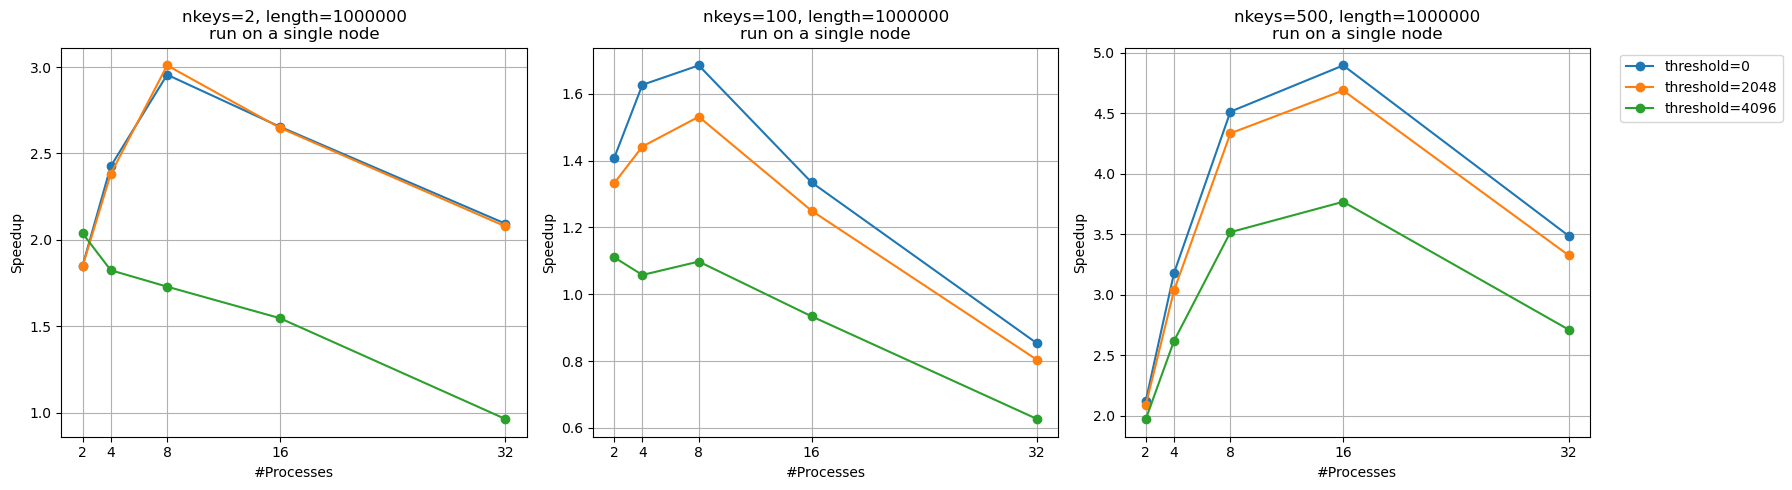

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
processes = metrics_2['ntasks'].unique()

for i, metrics in enumerate([metrics_2, metrics_100, metrics_500]): # for each number of keys
    for threshold in enumerate(metrics['threshold'].unique()): # for each threshold
        thr = threshold[1]
        metrics[metrics['threshold']==thr].plot(
            x='ntasks', y='speedup',
            style='o-', ax=axs[i], label=f'threshold={thr}'
        )
    axs[i].set_xlabel('#Processes')
    axs[i].set_ylabel('Speedup')
    axs[i].set_title(f"nkeys={metrics['nkeys'].unique()[0]}, length={length}\nrun on a single node")
    axs[i].set_xticks(ticks=processes, labels=processes)
    axs[i].legend().remove()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left');
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.tight_layout()
fig.savefig(f'./img/speedup_1node_strong.png')

Plotting cost:

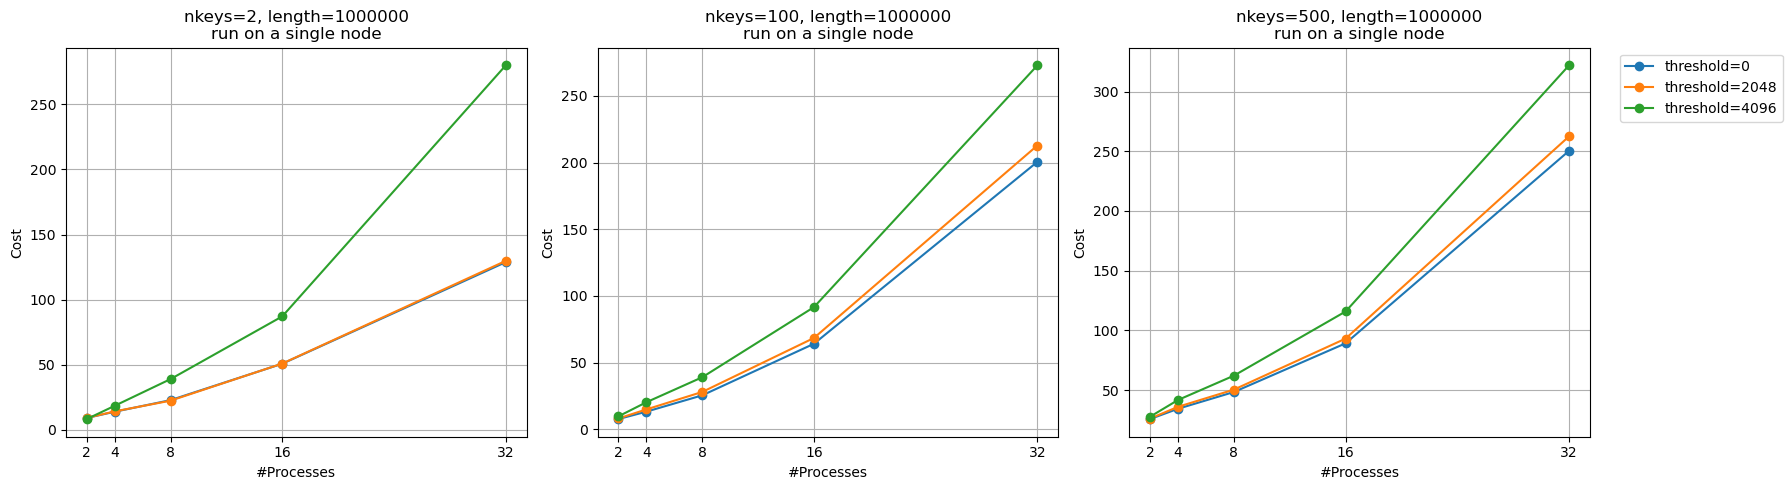

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metrics in enumerate([metrics_2, metrics_100, metrics_500]): # for each number of keys
    for threshold in enumerate(metrics['threshold'].unique()): # for each threshold
        thr = threshold[1]
        metrics[metrics['threshold']==thr].plot(
            x='ntasks', y='cost',
            style='o-', ax=axs[i], label=f'threshold={thr}'
        )
    axs[i].set_xlabel('#Processes')
    axs[i].set_ylabel('Cost')
    axs[i].set_title(f"nkeys={metrics['nkeys'].unique()[0]}, length={length}\nrun on a single node")
    axs[i].set_xticks(ticks=processes, labels=processes)
    axs[i].legend().remove()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left');
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.tight_layout()
fig.savefig(f'./img/cost_1node_strong.png')

Plotting efficiency:

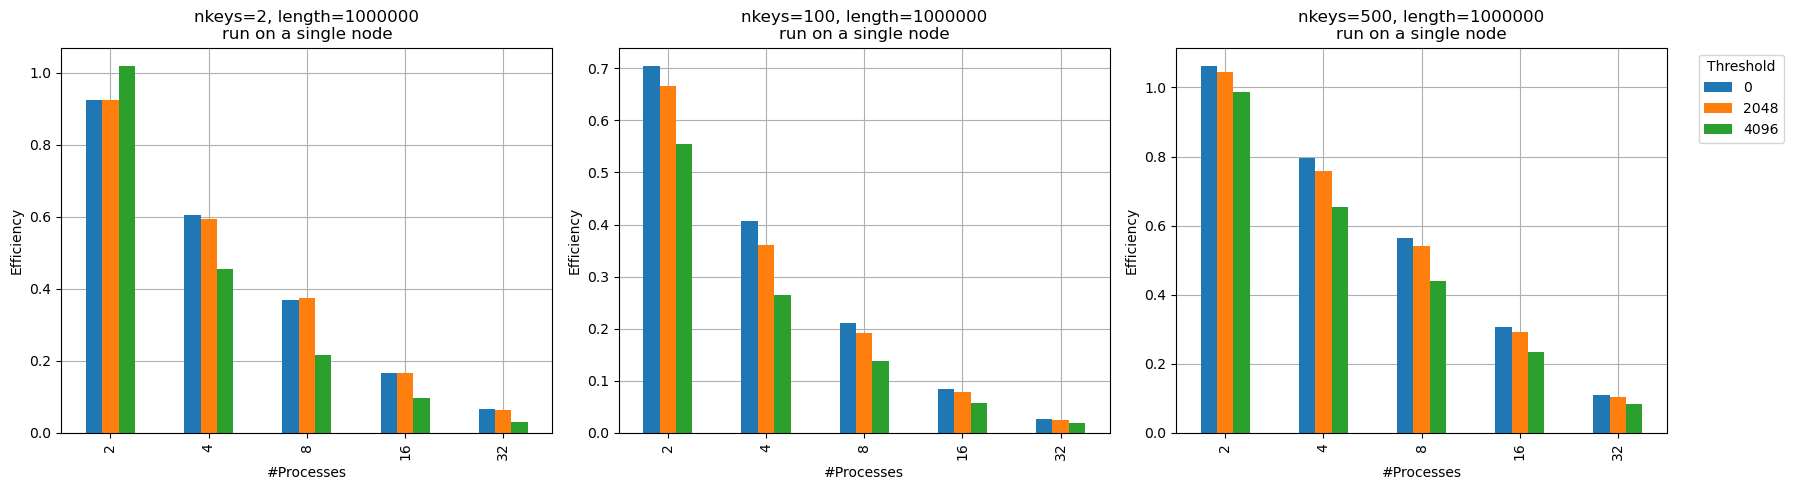

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metrics in enumerate([metrics_2, metrics_100, metrics_500]): # for each number of keys
    pivot_metrics = metrics.pivot(index='ntasks', columns='threshold', values='efficiency')
    pivot_metrics.plot.bar(grid=True, ax=axs[i])
    axs[i].set_axisbelow(True)
    axs[i].set_ylabel('Efficiency')
    axs[i].set_xlabel('#Processes')
    axs[i].set_title(f"nkeys={metrics['nkeys'].unique()[0]}, length={length}\nrun on a single node");
    axs[i].get_legend().remove()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Threshold');

fig.tight_layout()
fig.savefig(f'./img/efficiency_1node_strong.png')

### Weak scalability analysis

Loading execution timings of the parallel implementation when testing for weak scaling on a single node:

In [30]:
par_data_1node_weak = pd.read_csv('./results/par_timing_weak_1node.csv', header=None)
par_data_1node_weak.columns = ['ntasks', 'nkeys', 'length', 'threshold', 'time']
par_data_1node_weak

,ntasks,nkeys,length,threshold,time
0,2,50,1000000,0,3.441963
1,2,50,1000000,0,3.395641
2,2,50,1000000,0,3.390314
3,2,50,1000000,0,3.396706
4,2,50,1000000,0,3.407546
...,...,...,...,...,...
145,32,800,1000000,4096,12.116190
146,32,800,1000000,4096,12.091093
147,32,800,1000000,4096,12.087062
148,32,800,1000000,4096,12.062404


Grouping data:

In [31]:
par_data_1node_weak_grouped = par_data_1node_weak.groupby(['ntasks', 'nkeys', 'length', 'threshold'])['time'].agg(['mean', 'median', 'std'])
par_data_1node_weak_grouped.reset_index(inplace=True)
par_data_1node_weak_grouped.rename(columns={'median': 'par_median'}, inplace=True)
par_data_1node_weak_grouped

,ntasks,nkeys,length,threshold,mean,par_median,std
0,2,50,1000000,0,3.399270,3.396173,0.018504
1,2,50,1000000,2048,3.625110,3.616672,0.037053
2,2,50,1000000,4096,4.419601,4.406868,0.036421
3,4,100,1000000,0,3.221510,3.182017,0.211098
4,4,100,1000000,2048,3.748830,3.741956,0.110344
5,4,100,1000000,4096,5.015446,4.981347,0.130168
6,8,200,1000000,0,3.598774,3.584874,0.100722
7,8,200,1000000,2048,4.080211,4.088410,0.190861
8,8,200,1000000,4096,5.427658,5.436220,0.102740
9,16,400,1000000,0,5.061398,5.054452,0.031466


Computing performance metrics in the weak scaling setting:

In [32]:
data_weak_1node = seq_data_weak_grouped[['nkeys', 'seq_median']].merge(par_data_1node_weak_grouped, on=['nkeys'])
data_weak_1node['speedup'] = data_weak_1node['seq_median']/data_weak_1node['par_median']
data_weak_1node['cost'] = data_weak_1node['par_median']*data_weak_1node['ntasks']
data_weak_1node['efficiency'] = data_weak_1node['speedup']/data_weak_1node['ntasks']
data_weak_1node[['nkeys', 'threshold', 'ntasks', 'seq_median', 'par_median', 'speedup', 'cost', 'efficiency']]

,nkeys,threshold,ntasks,seq_median,par_median,speedup,cost,efficiency
0,50,0,2,4.542133,3.396173,1.337427,6.792347,0.668713
1,50,2048,2,4.542133,3.616672,1.255887,7.233345,0.627944
2,50,4096,2,4.542133,4.406868,1.030694,8.813736,0.515347
3,100,0,4,5.346449,3.182017,1.680207,12.728068,0.420052
4,100,2048,4,5.346449,3.741956,1.428784,14.967824,0.357196
5,100,4096,4,5.346449,4.981347,1.073294,19.925388,0.268323
6,200,0,8,8.547871,3.584874,2.384427,28.678996,0.298053
7,200,2048,8,8.547871,4.088410,2.090757,32.707280,0.261345
8,200,4096,8,8.547871,5.436220,1.572392,43.489760,0.196549
9,400,0,16,19.708188,5.054452,3.899174,80.871232,0.243698


Plotting metrics:

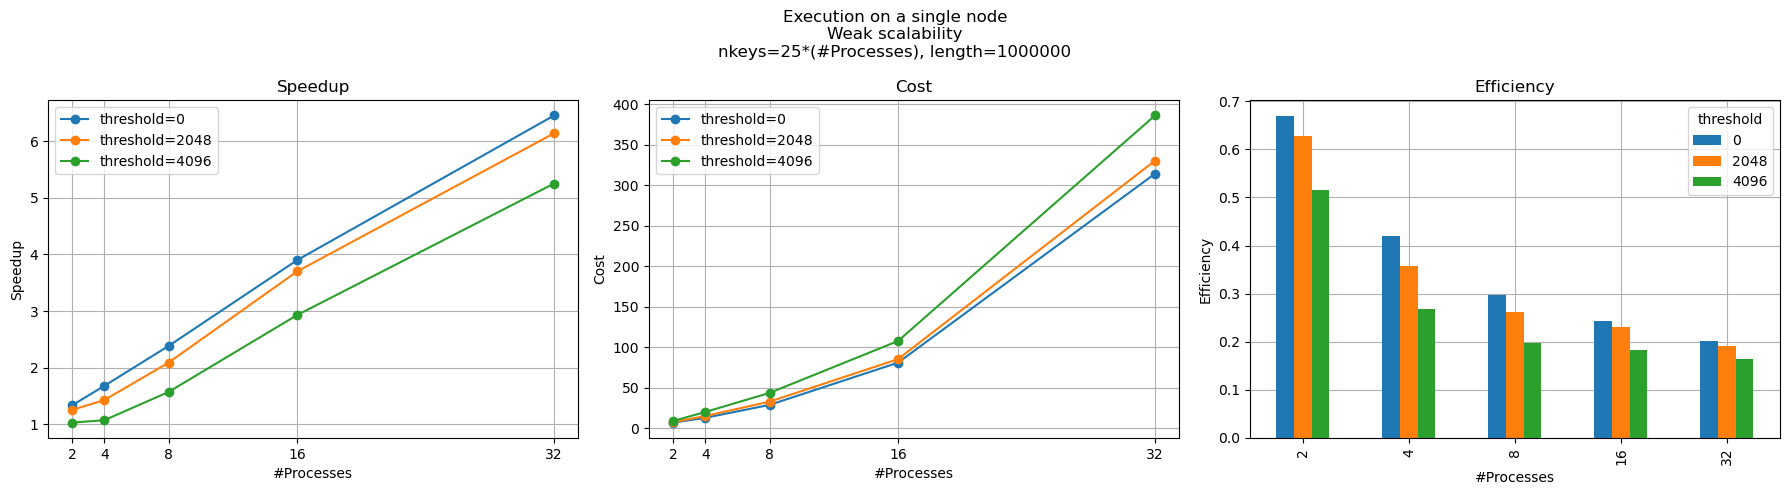

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plotting speedup
for threshold in enumerate(data_weak_1node['threshold'].unique()): # for each threshold
    thr = threshold[1]
    data_weak_1node[data_weak_1node['threshold']==thr].plot(
    x='ntasks', y='speedup',
    xlabel='#Processes', label=f'threshold={thr}', style='o-', ax=axs[0])
axs[0].set_ylabel('Speedup')
axs[0].grid()
processes = data_weak_1node['ntasks'].unique()
axs[0].set_xticks(ticks=processes, labels=processes)
axs[0].set_title(f'Speedup');

# Plotting cost
for threshold in enumerate(data_weak_1node['threshold'].unique()): # for each threshold
    thr = threshold[1]
    data_weak_1node[data_weak_1node['threshold']==thr].plot(
    x='ntasks', y='cost',
    xlabel='#Processes', label=f'threshold={thr}', style='o-', ax=axs[1])
axs[1].set_ylabel('Cost')
axs[1].grid()
processes = data_weak_1node['ntasks'].unique()
axs[1].set_xticks(ticks=processes, labels=processes)
axs[1].set_title(f'Cost');

# Plotting efficiency
pivot_weak_1node = data_weak_1node.pivot(index='ntasks', columns='threshold', values='efficiency')
pivot_weak_1node.plot.bar(grid=True, ax=axs[2])
axs[2].set_ylabel('Efficiency')
axs[2].set_xlabel('#Processes')
axs[2].set_axisbelow(True)
axs[2].set_title(f'Efficiency');

fig.suptitle(f'Execution on a single node\nWeak scalability\nnkeys=25*(#Processes), length={length}')
fig.tight_layout()
fig.savefig('./img/metrics_1node_weak.png')